**This is the main notebook containing the data cleaning + regressions that I used for most of the figures and tables presented in my thesis.**

In [371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pyreadstat
import requests
import statsmodels.api as smf
from stargazer.stargazer import Stargazer

In [372]:
# Look at Years 2000 - 2017
# Look only at Physicians and Surgeons, and Secretaries

medical_dict = {} 
medical_dict['291060'] = 'Physicians & Surgeons'
medical_dict['436010'] = 'Secretaries & Administrative Assistants'
medical_dict['311010'] = "Nursing, Psychiatric, and Home Health Aides"


medical_codes = list(medical_dict.keys())

medical_inds = {}
medical_inds[812] = 'Offices and clinics of physicians'
medical_inds[831] = 'Hospitals' 
medical_inds[832] = 'Nursing and personal care facilities' 

medical_ind_codes = list(medical_inds.keys())

In [373]:
# Assumptions: Looking only @ Full-Time, Full-Year Workers (35+ hours worked, 40+ weeks worked)

# read in IPUMS Data and take only full-time full-year workers in medical jobs and industries
# also only take ages 18-65

TextFileReader = pd.read_csv("data/usa_00010.csv", chunksize = 20000)

def calculate_emp(x, y): 
    if (x == 1): 
        return x*y
    else: 
        return 0 

dfList_medical = []
counter = 0
for df in TextFileReader: 
    
    # extract important rows 
    df = df[(df['AGE'] >= 18) & (df['AGE'] <= 65)]
    
    # get only occupations of interest from 2000 to 2017 
    df = df[(df['OCCSOC'].isin(medical_codes)) & (df['IND1990'].isin(medical_ind_codes))]
    
    # get full-time, full-year workers (35+ hours/wk, 40+ wks/yr)
    df = df[(df['UHRSWORK'] >= 35)]
    df = df[(df['WKSWORK1'] >= 40) | (df['WKSWORK2'] >= 4)]
    
    dfList_medical.append(df)
    
    # verbose...
    counter += 1 
    if (counter % 100 == 0): 
        print("processed ", round(counter*20000*100/65483126, 3), " percent of rows")

df_medical = pd.concat(dfList_medical, sort=False)
df_medical

processed  3.054  percent of rows
processed  6.108  percent of rows
processed  9.163  percent of rows
processed  12.217  percent of rows
processed  15.271  percent of rows
processed  18.325  percent of rows
processed  21.38  percent of rows
processed  24.434  percent of rows
processed  27.488  percent of rows
processed  30.542  percent of rows
processed  33.596  percent of rows
processed  36.651  percent of rows
processed  39.705  percent of rows
processed  42.759  percent of rows
processed  45.813  percent of rows
processed  48.868  percent of rows
processed  51.922  percent of rows
processed  54.976  percent of rows
processed  58.03  percent of rows
processed  61.084  percent of rows
processed  64.139  percent of rows
processed  67.193  percent of rows
processed  70.247  percent of rows
processed  73.301  percent of rows
processed  76.356  percent of rows
processed  79.41  percent of rows
processed  82.464  percent of rows
processed  85.518  percent of rows
processed  88.572  percent

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEICP,STRATA,GQ,PERNUM,...,OCCSOC,IND,IND1990,INDNAICS,WKSWORK1,WKSWORK2,UHRSWORK,LOOKING,WORKEDYR,INCWAGE
40,2000,200001,19,NaN,13,2000000000191,5,64,1,1,...,291060,797,812,6211,52.0,6,50,0,3,0
47,2000,200001,22,NaN,18,2000000000221,5,113,1,2,...,311010,827,832,6231,48.0,5,40,0,3,17100
49,2000,200001,22,NaN,18,2000000000221,5,113,1,4,...,311010,827,832,6231,48.0,5,40,3,3,27500
314,2000,200001,143,NaN,37,2000000001431,5,124,1,2,...,311010,827,832,6231,50.0,6,67,0,3,10100
348,2000,200001,157,NaN,18,2000000001571,5,65,1,1,...,291060,797,812,6211,48.0,5,60,0,3,294000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59027808,2017,201701,1393777,2.017001e+12,21,2017013937771,68,10056,1,1,...,291060,7970,812,6211,NaN,6,60,3,3,0
59027811,2017,201701,1393779,2.017001e+12,341,2017013937791,68,50056,1,1,...,311010,8190,831,622,NaN,6,40,3,3,60000
59027812,2017,201701,1393779,2.017001e+12,341,2017013937791,68,50056,1,2,...,311010,8190,831,622,NaN,6,40,3,3,96000
59028448,2017,201701,1394041,2.017001e+12,122,2017013940411,68,20056,1,2,...,311010,8190,831,622,NaN,6,48,3,3,28800


**WAGE REGRESSIONS**

In [374]:
# SOURCE: https://usa.ipums.org/usa/cpi99.shtml
cpi99 = {} 
cpi99[1980] = 2.295 
cpi99[1990] = 1.344
cpi99[2000] = 0.967
cpi99[2001] = 0.941
cpi99[2002] = 0.926
cpi99[2003] = 0.905
cpi99[2004] = 0.882
cpi99[2005] = 0.853
cpi99[2006] = 0.826
cpi99[2007] = 0.804
cpi99[2008] = 0.774
cpi99[2009] = 0.777
cpi99[2010] = 0.764
cpi99[2011] = 0.741
cpi99[2012] = 0.726
cpi99[2013] = 0.715
cpi99[2014] = 0.704
cpi99[2015] = 0.703
cpi99[2016] = 0.694
cpi99[2017] = 0.679
cpi99[2018] = 0.663
cpi99[2019] = 0.652

def convert_99(x, y):
    return cpi99[x]*y

In [375]:
# need to only look at those who are employed and years 2005 to 2017
df_medical = df_medical[(df_medical['YEAR'] >= 2005) & (df_medical['YEAR'] <= 2017)]
df_medical = df_medical[df_medical['EMPSTAT'] == 1]
df_medical = df_medical[df_medical['INCWAGE'] != 0]
df_medical['INCWAGE_REAL'] = df_medical.apply(lambda x: convert_99(x['YEAR'], x['INCWAGE']), axis=1)

df_medical['PERWTSEX'] = df_medical.apply(lambda x: [x['PERWT'], x['SEX']], axis=1)
df_medical['PERWTRACE'] = df_medical.apply(lambda x: [x['PERWT'], x['RACE']], axis=1)
df_medical['PERWTEDUC'] = df_medical.apply(lambda x: [x['PERWT'], x['EDUC']], axis=1)
df_medical

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEICP,STRATA,GQ,PERNUM,...,WKSWORK1,WKSWORK2,UHRSWORK,LOOKING,WORKEDYR,INCWAGE,INCWAGE_REAL,PERWTSEX,PERWTRACE,PERWTEDUC
19109351,2005,200501,77,4.709000e+03,83,2005000000771,41,170001,1,1,...,40.0,4,42,1,3,12000,10236.0,"[79, 2]","[79, 8]","[79, 7]"
19109468,2005,200501,129,7.886000e+03,84,2005000001291,41,170001,1,1,...,52.0,6,60,3,3,15000,12795.0,"[82, 2]","[82, 1]","[82, 5]"
19109541,2005,200501,164,9.502000e+03,73,2005000001641,41,100001,1,1,...,52.0,6,40,1,3,22000,18766.0,"[70, 2]","[70, 2]","[70, 6]"
19110232,2005,200501,472,2.832800e+04,48,2005000004721,41,210001,1,2,...,52.0,6,40,3,3,10000,8530.0,"[51, 2]","[51, 2]","[51, 8]"
19110372,2005,200501,532,3.207200e+04,84,2005000005321,41,130001,1,1,...,52.0,6,70,3,3,315000,268695.0,"[85, 1]","[85, 1]","[85, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59027742,2017,201701,1393751,2.017001e+12,22,2017013937511,68,10056,1,1,...,NaN,6,50,3,3,24000,16296.0,"[22, 2]","[22, 1]","[22, 7]"
59027811,2017,201701,1393779,2.017001e+12,341,2017013937791,68,50056,1,1,...,NaN,6,40,3,3,60000,40740.0,"[341, 2]","[341, 1]","[341, 7]"
59027812,2017,201701,1393779,2.017001e+12,341,2017013937791,68,50056,1,2,...,NaN,6,40,3,3,96000,65184.0,"[368, 1]","[368, 1]","[368, 7]"
59028448,2017,201701,1394041,2.017001e+12,122,2017013940411,68,20056,1,2,...,NaN,6,48,3,3,28800,19555.2,"[70, 2]","[70, 1]","[70, 6]"


In [376]:
ind_totals = df_medical.groupby(['YEAR', 'OCCSOC', 'IND1990']).agg('sum').reset_index()[['YEAR', 'OCCSOC', 
                                                                                        'IND1990', 'PERWT']]

occ_totals = ind_totals.groupby(['YEAR', 'OCCSOC']).agg('sum').reset_index()[['YEAR', 'OCCSOC', 'PERWT']]

ind_totals.columns = ['YEAR', 'OCCSOC', 'IND1990', 'INDTOTAL']
occ_totals.columns = ['YEAR', 'OCCSOC', 'OCCTOTAL']

df = pd.merge(df_medical, ind_totals, how='inner', on=['YEAR', 'OCCSOC', 'IND1990'])
df = pd.merge(df, occ_totals, how='inner', on=['YEAR', 'OCCSOC'])
df

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEICP,STRATA,GQ,PERNUM,...,UHRSWORK,LOOKING,WORKEDYR,INCWAGE,INCWAGE_REAL,PERWTSEX,PERWTRACE,PERWTEDUC,INDTOTAL,OCCTOTAL
0,2005,200501,77,4.709000e+03,83,2005000000771,41,170001,1,1,...,42,1,3,12000,10236.0,"[79, 2]","[79, 8]","[79, 7]",13980,302174
1,2005,200501,8701,5.317710e+05,27,2005000087011,41,260001,1,1,...,50,3,3,17000,14501.0,"[27, 2]","[27, 1]","[27, 6]",13980,302174
2,2005,200501,34085,5.196950e+05,83,2005000340851,61,10704,1,1,...,40,3,3,22000,18766.0,"[85, 2]","[85, 1]","[85, 6]",13980,302174
3,2005,200501,40476,8.342740e+05,72,2005000404761,61,10304,1,2,...,40,3,3,39000,33267.0,"[76, 2]","[76, 1]","[76, 7]",13980,302174
4,2005,200501,55482,6.349280e+05,30,2005000554821,42,130005,1,2,...,40,3,3,10000,8530.0,"[32, 2]","[32, 1]","[32, 6]",13980,302174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201872,2017,201701,1376251,2.017001e+12,98,2017013762511,25,7010155,1,2,...,40,3,3,8000,5432.0,"[150, 2]","[150, 1]","[150, 8]",75821,251350
201873,2017,201701,1383230,2.017001e+12,48,2017013832301,25,130155,1,2,...,40,3,3,30000,20370.0,"[41, 2]","[41, 1]","[41, 8]",75821,251350
201874,2017,201701,1384791,2.017001e+12,34,2017013847911,25,5510155,1,2,...,40,3,3,30000,20370.0,"[36, 2]","[36, 1]","[36, 7]",75821,251350
201875,2017,201701,1387838,2.017001e+12,39,2017013878381,25,250055,1,1,...,40,3,3,37000,25123.0,"[39, 2]","[39, 1]","[39, 6]",75821,251350


In [377]:
df['INDWEIGHT'] = df['PERWT']/df['INDTOTAL']
df['OCCWEIGHT'] = df['PERWT']/df['OCCTOTAL']

df['INDINCWAGE_REAL'] = df['INCWAGE_REAL']*df['INDWEIGHT']
df['OCCINCWAGE_REAL'] = df['INCWAGE_REAL']*df['OCCWEIGHT']

df_plot = df.groupby(['YEAR', 'OCCSOC']).agg('sum').reset_index()

,YEAR,OCCSOC,PERWT
0,2005,291060,507721
1,2005,311010,726428
2,2005,436010,302174
3,2006,291060,512743
4,2006,311010,733707
5,2006,436010,291919
6,2007,291060,528366
7,2007,311010,756582
8,2007,436010,291452
9,2008,291060,539996


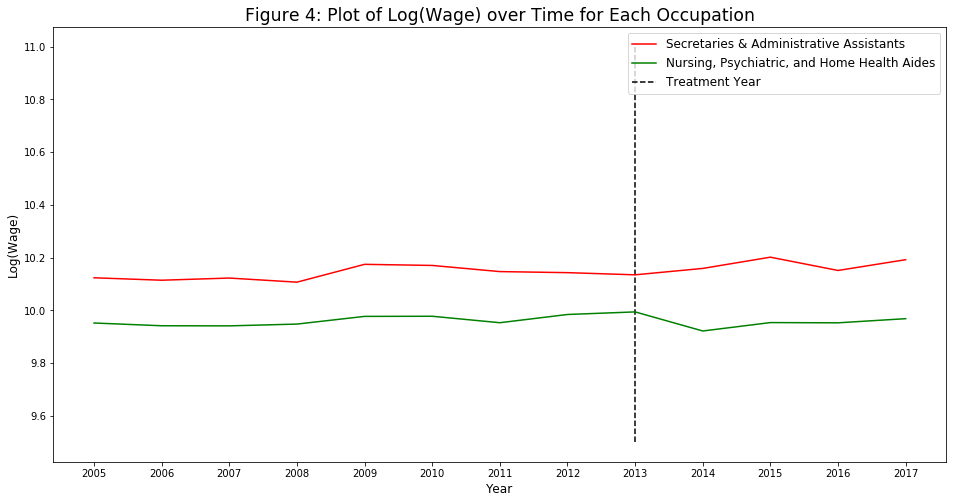

In [463]:
# wages

physicians = np.log(df_plot[df_plot['OCCSOC']=='291060']['OCCINCWAGE_REAL'])
secretaries = np.log(df_plot[df_plot['OCCSOC']=='436010']['OCCINCWAGE_REAL'])
aides = np.log(df_plot[df_plot['OCCSOC']=='311010']['OCCINCWAGE_REAL'])

plt.figure(figsize=(16,8))
years = np.arange(2005,2018,1)
#plt.plot(years, physicians, label='Physicians & Surgeons', color='blue')
plt.plot(years, secretaries, label = 'Secretaries & Administrative Assistants', color='red')
plt.plot(years, aides, label = 'Nursing, Psychiatric, and Home Health Aides', color='green')
plt.xticks(years)
plt.vlines(2013, 9.5, 11,linestyle="dashed", label='Treatment Year')
plt.title("Figure 4: Plot of Log(Wage) over Time for Each Occupation", fontsize='xx-large')
plt.xlabel("Year", fontsize = 'large')
plt.ylabel("Log(Wage)", fontsize='large')
plt.legend(fontsize='large')

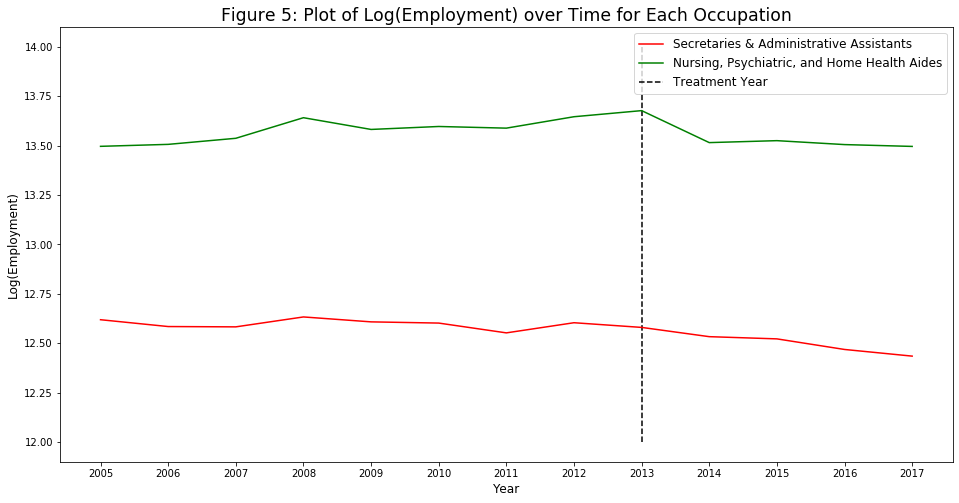

In [465]:
# employment
physicians = np.log(df_plot[df_plot['OCCSOC']=='291060']['PERWT'])
secretaries = np.log(df_plot[df_plot['OCCSOC']=='436010']['PERWT'])
aides = np.log(df_plot[df_plot['OCCSOC']=='311010']['PERWT'])

plt.figure(figsize=(16,8))
years = np.arange(2005,2018,1)
#plt.plot(years, physicians, label='Physicians & Surgeons', color='blue')
plt.plot(years, secretaries, label = 'Secretaries & Administrative Assistants', color='red')
plt.plot(years, aides, label = 'Nursing, Psychiatric, and Home Health Aides', color='green')
plt.xticks(years)
plt.title("Figure 5: Plot of Log(Employment) over Time for Each Occupation", fontsize='xx-large')
plt.xlabel("Year", fontsize='large')
plt.ylabel("Log(Employment)", fontsize='large')
plt.vlines(2013, 12, 14, linestyle="dashed", label='Treatment Year')
plt.legend(fontsize='large')

In [381]:
def fracfemale(series): 
    num_female = 0
    total = 0
    for elem in series: 
        if (elem[1] == 2): 
            num_female += elem[0]
        total += elem[0]
        
    return num_female/total

def fraccollege(series): 
    num_college = 0
    total = 0
    for elem in series: 
        if (elem[1] >= 7): 
            num_college += elem[0]
        total += elem[0]
        
    return num_college/total

def fracwhite(series): 
    num_white = 0
    total = 0
    for elem in series: 
        if (elem[1] == 1): 
            num_white += elem[0]
        total += elem[0]
        
    return num_white/total

In [382]:
# group by year and occupational code 
occ_effects = df.groupby(['YEAR', 'OCCSOC', 'IND1990']).agg({'PERWTEDUC': fraccollege, 
                                                             'AGE': 'mean',
                                                             'PERWTRACE': fracwhite,
                                                             'PERWTSEX': fracfemale
                                                            }).reset_index()




In [383]:
# group by year, occupational code, and industry 
df_medical_grp = df.groupby(['YEAR', 'OCCSOC', 'IND1990']).agg({'INDINCWAGE_REAL': 'sum',
                                                                        'PERWT': 'sum',
                                                                        }).reset_index()

df_medical_grp

,YEAR,OCCSOC,IND1990,INDINCWAGE_REAL,PERWT
0,2005,291060,812,181534.643696,255303
1,2005,291060,831,119883.487973,251334
2,2005,291060,832,127549.467712,1084
3,2005,311010,812,28282.440356,22450
4,2005,311010,831,23801.094071,286427
...,...,...,...,...,...
112,2017,311010,831,23648.104872,318078
113,2017,311010,832,18838.504645,383576
114,2017,436010,812,27210.035962,75821
115,2017,436010,831,26511.028677,159035


In [384]:
# merge occ effects in 
df_medical_grp = pd.merge(df_medical_grp, occ_effects, how='inner', on=['YEAR', 'OCCSOC', 'IND1990'])

# transform all control columns to log 
df_medical_grp['FRACCOLLEGE'] = np.log(df_medical_grp['PERWTEDUC'])
df_medical_grp['FRACWHITE'] = np.log(df_medical_grp['PERWTRACE'])
df_medical_grp['FRACFEMALE'] = np.log(df_medical_grp['PERWTSEX'])
df_medical_grp['AGE'] = np.log(df_medical_grp['AGE'])

# transform outcome variables
df_medical_grp['LOGWAGE'] = np.log(df_medical_grp['INDINCWAGE_REAL'])
df_medical_grp['LOGEMP'] = np.log(df_medical_grp['PERWT'])

In [385]:
wage_df_med = df_medical_grp[['YEAR', 'OCCSOC','IND1990','FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 
                              'AGE', 'LOGWAGE']]
emp_df_med = df_medical_grp[['YEAR', 'OCCSOC','IND1990','FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 
                             'AGE', 'LOGEMP']]

wage_df_med

,YEAR,OCCSOC,IND1990,FRACCOLLEGE,FRACWHITE,FRACFEMALE,AGE,LOGWAGE
0,2005,291060,812,-0.000839,-0.208897,-1.470369,3.860072,12.109202
1,2005,291060,831,-0.001222,-0.375400,-1.054276,3.711950,11.694276
2,2005,291060,832,0.000000,-0.188243,-0.789934,3.881564,11.756260
3,2005,311010,812,-0.600879,-0.408722,-0.125407,3.677554,10.249996
4,2005,311010,831,-0.877428,-0.641251,-0.209407,3.726242,10.077487
...,...,...,...,...,...,...,...,...
112,2017,311010,831,-0.549619,-0.637761,-0.262427,3.705557,10.071038
113,2017,311010,832,-1.025427,-0.742804,-0.092579,3.711024,9.843658
114,2017,436010,812,-0.540375,-0.168196,-0.028603,3.814351,10.211341
115,2017,436010,831,-0.475369,-0.374781,-0.048955,3.856544,10.185316


In [386]:
# Create datasets
pa_wage = wage_df_med.loc[(wage_df_med['OCCSOC']== '291060') | (wage_df_med['OCCSOC']== '311010')]
sa_wage = wage_df_med.loc[(wage_df_med['OCCSOC']== '436010') | (wage_df_med['OCCSOC']== '311010')]

pa_wage['Pre'] = pa_wage['YEAR'].apply(lambda x: 1 if x < 2013 else 0)
pa_wage['Post'] = pa_wage['YEAR'].apply(lambda x: 1 if x >= 2013 else 0)
pa_wage['AI'] = pa_wage['OCCSOC'].apply(lambda x: 1 if x == '291060' else 0)
pa_wage['AIPost'] = pa_wage['AI']*pa_wage['Post']

sa_wage['Pre'] = sa_wage['YEAR'].apply(lambda x: 1 if x < 2013 else 0)
sa_wage['Post'] = sa_wage['YEAR'].apply(lambda x: 1 if x >= 2013 else 0)
sa_wage['AI'] = sa_wage['OCCSOC'].apply(lambda x: 1 if x == '436010' else 0)
sa_wage['AIPost'] = sa_wage['AI']*sa_wage['Post']

pa_wage.to_csv("data/physicians_aides_wage_single.csv")
sa_wage.to_csv("data/secretary_aides_wage_single.csv")

/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [387]:
# Create datasets
pa_emp = emp_df_med.loc[(emp_df_med['OCCSOC']== '291060') | (emp_df_med['OCCSOC']== '311010')]
sa_emp = emp_df_med.loc[(emp_df_med['OCCSOC']== '436010') | (emp_df_med['OCCSOC']== '311010')]

pa_emp['Pre'] = pa_emp['YEAR'].apply(lambda x: 1 if x < 2013 else 0)
pa_emp['Post'] = pa_emp['YEAR'].apply(lambda x: 1 if x >= 2013 else 0)
pa_emp['AI'] = pa_emp['OCCSOC'].apply(lambda x: 1 if x == '291060' else 0)
pa_emp['AIPost'] = pa_emp['AI']*pa_emp['Post']

sa_emp['Pre'] = sa_emp['YEAR'].apply(lambda x: 1 if x < 2013 else 0)
sa_emp['Post'] = sa_emp['YEAR'].apply(lambda x: 1 if x >= 2013 else 0)
sa_emp['AI'] = sa_emp['OCCSOC'].apply(lambda x: 1 if x == '436010' else 0)
sa_emp['AIPost'] = sa_emp['AI']*sa_emp['Post']

pa_emp.to_csv("data/physicians_aides_emp_single.csv")
sa_emp.to_csv("data/secretary_aides_emp_single.csv")

/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sidsatya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [388]:
# get data for number of patents and merge for each occupation
aipatents_world = pd.read_csv("data/aipatents_world.csv")
aw_wage = aipatents_world.iloc[3:, :].reset_index()[['num_patents']]/1000
aw_wage['Year'] = np.arange(2001, 2018, 1)

pa_wage_ols = pd.merge(pa_wage, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index()
sa_wage_ols = pd.merge(sa_wage, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index()

pa_wage_ols.to_csv("data/pa_wage_single_ols.csv")
sa_wage_ols.to_csv("data/sa_wage_single_ols.csv")

In [389]:
p_wage = pa_wage[pa_wage['OCCSOC'] == '291060'].iloc[:, :-4]
a_wage = pa_wage[pa_wage['OCCSOC'] == '311010'].iloc[:, :-4]
s_wage = sa_wage[sa_wage['OCCSOC'] == '436010'].iloc[:, :-4]

p_wage_ols = pd.merge(p_wage, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]
s_wage_ols = pd.merge(s_wage, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]
a_wage_ols = pd.merge(a_wage, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]

p_wage_ols.to_csv("data/p_wage_ols.csv")
s_wage_ols.to_csv("data/s_wage_ols.csv")
a_wage_ols.to_csv("data/a_wage_ols.csv")

#p_wage_ols = p_wage_ols[p_wage_ols['IND1990'] == 812]

p_emp = pa_emp[pa_emp['OCCSOC'] == '291060']
a_emp = pa_emp[pa_emp['OCCSOC'] == '311010']
s_emp = sa_emp[sa_emp['OCCSOC'] == '436010']

p_emp_ols = pd.merge(p_emp, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]
s_emp_ols = pd.merge(s_emp, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]
a_emp_ols = pd.merge(a_emp, aw_wage, how='inner', left_on='YEAR', right_on='Year').reset_index().iloc[:,:-1]

p_emp_ols.to_csv("data/p_emp_ols.csv")
s_emp_ols.to_csv("data/s_emp_ols.csv")
a_emp_ols.to_csv("data/a_emp_ols.csv")

In [391]:
aipatents_world = pd.read_csv("data/aipatents_world.csv")
aw_emp = aipatents_world.iloc[3:, :].reset_index()[['num_patents']]
aw_emp['num_patents'] = aw_emp['num_patents']/1000
aw_emp['Year'] = np.arange(2001, 2018, 1)

pa_emp_ols = pd.merge(pa_emp, aw_emp, how='inner', left_on='YEAR', right_on='Year').reset_index()
sa_emp_ols = pd.merge(sa_emp, aw_emp, how='inner', left_on='YEAR', right_on='Year').reset_index()

pa_emp_ols.to_csv("data/pa_emp_single_ols.csv")
sa_wage_ols.to_csv("data/sa_emp_single_ols.csv")

In [400]:
np.mean(np.exp(pa_emp[pa_emp['OCCSOC']=='291060'][['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'AGE']]))

FRACCOLLEGE     0.994412
FRACWHITE       0.727349
FRACFEMALE      0.353524
AGE            46.421073
dtype: float64

In [401]:
np.mean(np.exp(pa_emp[pa_emp['OCCSOC']=='311010'][['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'AGE']]))

FRACCOLLEGE     0.467264
FRACWHITE       0.591146
FRACFEMALE      0.864478
AGE            40.821222
dtype: float64

In [402]:
np.mean(np.exp(sa_emp[sa_emp['OCCSOC']=='436010'][['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'AGE']]))

FRACCOLLEGE     0.537526
FRACWHITE       0.795275
FRACFEMALE      0.966970
AGE            45.734335
dtype: float64

In [433]:
df_medical_grp

,YEAR,OCCSOC,IND1990,INDINCWAGE_REAL,PERWT,PERWTEDUC,AGE,PERWTRACE,PERWTSEX,FRACCOLLEGE,FRACWHITE,FRACFEMALE,LOGWAGE,LOGEMP
0,2005,291060,812,181534.643696,255303,0.999162,3.860072,0.811479,0.229841,-0.000839,-0.208897,-1.470369,12.109202,12.450206
1,2005,291060,831,119883.487973,251334,0.998779,3.711950,0.687014,0.348445,-0.001222,-0.375400,-1.054276,11.694276,12.434538
2,2005,291060,832,127549.467712,1084,1.000000,3.881564,0.828413,0.453875,0.000000,-0.188243,-0.789934,11.756260,6.988413
3,2005,311010,812,28282.440356,22450,0.548330,3.677554,0.664499,0.882138,-0.600879,-0.408722,-0.125407,10.249996,10.019046
4,2005,311010,831,23801.094071,286427,0.415851,3.726242,0.526633,0.811065,-0.877428,-0.641251,-0.209407,10.077487,12.565239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2017,311010,831,23648.104872,318078,0.577170,3.705557,0.528474,0.769182,-0.549619,-0.637761,-0.262427,10.071038,12.670052
113,2017,311010,832,18838.504645,383576,0.358643,3.711024,0.475778,0.911577,-1.025427,-0.742804,-0.092579,9.843658,12.857293
114,2017,436010,812,27210.035962,75821,0.582530,3.814351,0.845188,0.971802,-0.540375,-0.168196,-0.028603,10.211341,11.236131
115,2017,436010,831,26511.028677,159035,0.621656,3.856544,0.687440,0.952224,-0.475369,-0.374781,-0.048955,10.185316,11.976880


In [458]:
p = df_medical_grp[df_medical_grp['OCCSOC'] == '291060']
s = df_medical_grp[df_medical_grp['OCCSOC'] == '436010']
n = df_medical_grp[df_medical_grp['OCCSOC'] == '311010']

p_means = np.mean(np.exp(p[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))
s_means = np.mean(np.exp(s[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))
n_means = np.mean(np.exp(n[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))

means = pd.concat([p_means, s_means, n_means], axis=1)
means.columns = ["Physicians & Surgeons", "Secretaries & Administrative Assistants", "Nursing, Psychiatric, and Home Health Aides"]
means =means.rename({'FRACCOLLEGE': 'Frac. College',
              'FRACWHITE': 'Frac. White', 
              'FRACFEMALE': 'Frac. Female', 
              'LOGWAGE': 'Real Wage', 
              'LOGEMP': 'Employment'}, axis='index')
means

,Physicians & Surgeons,Secretaries & Administrative Assistants,"Nursing, Psychiatric, and Home Health Aides"
Frac. College,0.994412,0.537526,0.467264
Frac. White,0.727349,0.795275,0.591146
Frac. Female,0.353524,0.966970,0.864478
Real Wage,146749.647481,25438.125379,24243.412502
Employment,185065.153846,95433.615385,259183.538462


In [459]:
p_std = np.std(np.exp(p[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))
s_std = np.std(np.exp(s[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))
n_std = np.std(np.exp(n[['FRACCOLLEGE', 'FRACWHITE', 'FRACFEMALE', 'LOGWAGE', 'LOGEMP']]))

stds = pd.concat([p_std, s_std, n_std], axis=1)
stds.columns = ["Physicians & Surgeons", "Secretaries & Administrative Assistants", "Nursing, Psychiatric, and Home Health Aides"]
stds =stds.rename({'FRACCOLLEGE': 'Frac. College',
              'FRACWHITE': 'Frac. White', 
              'FRACFEMALE': 'Frac. Female', 
              'LOGWAGE': 'Real Wage', 
              'LOGEMP': 'Employment'}, axis='index')
stds

,Physicians & Surgeons,Secretaries & Administrative Assistants,"Nursing, Psychiatric, and Home Health Aides"
Frac. College,0.020426,0.051286,0.120127
Frac. White,0.073906,0.059985,0.104669
Frac. Female,0.081651,0.019081,0.057320
Real Wage,30509.734387,1036.171233,5195.029594
Employment,135743.500582,68493.601639,172881.349548


In [454]:
ind_occ_means = df.groupby(['IND1990', 'OCCSOC']).agg({'YEAR':'count',
                                      'PERWTEDUC': fraccollege, 
                                      'AGE': 'mean',
                                      'PERWTRACE': fracwhite,
                                      'PERWTSEX': fracfemale})

ind_occ_means = ind_occ_means.reset_index() 
ind_occ_means

,IND1990,OCCSOC,YEAR,PERWTEDUC,AGE,PERWTRACE,PERWTSEX
0,812,291060,33007,0.997001,48.528130,0.771400,0.272850
1,812,311010,2907,0.581406,39.881321,0.733219,0.895050
2,812,436010,11303,0.535266,44.295497,0.859418,0.972670
3,831,291060,40990,0.996168,41.881313,0.674343,0.375245
4,831,311010,37618,0.501144,41.770163,0.529979,0.787264
5,831,436010,24342,0.566259,46.329513,0.723596,0.961713
6,832,291060,178,0.993043,48.994382,0.733241,0.427207
7,832,311010,49146,0.323127,40.862512,0.513446,0.908935
8,832,436010,2386,0.508329,46.483655,0.802800,0.967025


In [455]:
ind_occ_means['IND1990'] = ind_occ_means['IND1990'].apply(lambda x: medical_inds[x])
ind_occ_means['OCCSOC'] = ind_occ_means['OCCSOC'].apply(lambda x: medical_dict[x])
ind_occ_means.columns = ind_occ_means.columns = ['Industry', 'Occupation','Num. Observations', 'Mean Frac. College', 
                                                 'Mean Age', 'Mean Frac. White', 'Mean Frac. Female']
ind_occ_means.set_index(['Industry', 'Occupation'])

Num. Observations  \
Industry                             Occupation                                                       
Offices and clinics of physicians    Physicians & Surgeons                                    33007   
                                     Nursing, Psychiatric, and Home Health Aides               2907   
                                     Secretaries & Administrative Assistants                  11303   
Hospitals                            Physicians & Surgeons                                    40990   
                                     Nursing, Psychiatric, and Home Health Aides              37618   
                                     Secretaries & Administrative Assistants                  24342   
Nursing and personal care facilities Physicians & Surgeons                                      178   
                                     Nursing, Psychiatric, and Home Health Aides              49146   
                                     Secretaries & Administrative Assistants                   2386   

                                                                                  Mean Frac. College  \
Industry                             Occupation                                                        
Offices and clinics of physicians    Physicians & Surgeons                                  0.997001   
                                     Nursing, Psychiatric, and Home Health Aides            0.581406   
                                     Secretaries & Administrative Assistants                0.535266   
Hospitals                            Physicians & Surgeons                                  0.996168   
                                     Nursing, Psychiatric, and Home Health Aides            0.501144   
                                     Secretaries & Administrative Assistants                0.566259   
Nursing and personal care facilities Physicians & Surgeons                                  0.993043   
                                     Nursing, Psychiatric, and Home Health Aides            0.323127   
                                     Secretaries & Administrative Assistants                0.508329   

                                                                                   Mean Age  \
Industry                             Occupation                                               
Offices and clinics of physicians    Physicians & Surgeons                        48.528130   
                                     Nursing, Psychiatric, and Home Health Aides  39.881321   
                                     Secretaries & Administrative Assistants      44.295497   
Hospitals                            Physicians & Surgeons                        41.881313   
                                     Nursing, Psychiatric, and Home Health Aides  41.770163   
                                     Secretaries & Administrative Assistants      46.329513   
Nursing and personal care facilities Physicians & Surgeons                        48.994382   
                                     Nursing, Psychiatric, and Home Health Aides  40.862512   
                                     Secretaries & Administrative Assistants      46.483655   

                                                                                  Mean Frac. White  \
Industry                             Occupation                                                      
Offices and clinics of physicians    Physicians & Surgeons                                0.771400   
                                     Nursing, Psychiatric, and Home Health Aides          0.733219   
                                     Secretaries & Administrative Assistants              0.859418   
Hospitals                            Physicians & Surgeons                                0.674343   
                                     Nursing, Psychiatric, and Home Health Aides          0.529979   
                                     Secret